In [1]:
import numpy as np
import pandas as pd
import sys,glob,os

import matplotlib.pyplot as plt
import matplotlib

sys.path.append(sys.path[0] + '/../MeasureMSP')

from imp import reload
import platereaderclass as prc; reload(prc);
import plateimageclass as pic; reload(pic);
import plates_EstimateMSP as eMSP; reload(eMSP);

In [2]:
ChangeEPS_label = r'$E.\,coli~\mathrm{MG1655}$'
ChangeRHO_label = r'$E.\,coli~\mathrm{BW27783}$'

all_datafiles = glob.glob('../ExperimentalData/Change???/*.xlsx')
alldata = prc.PlateReaderData(infiles = all_datafiles, ForceEqualDesignSpacing = True)
global_threshold = alldata.threshold

print(global_threshold)

0.14074726961987657


In [3]:
def ReadDesignAssignment(filename):
    f = open(filename,'r')
    ret = dict()
    filenames = []
    for line in f.readlines():
        v = line.split()
        ret[v[0]] = list(int(x) for x in v[1:])
        filenames.append(os.path.dirname(filename) + '/' + v[0])
    return filenames, ret

datafiles_cEPS, designassignment_cEPS = ReadDesignAssignment('../ExperimentalData/ChangeEPS/design_assignment.txt')

print(datafiles_cEPS)
print(designassignment_cEPS)

['../ExperimentalData/ChangeEPS/ChangeEPS_suscWT.xlsx', '../ExperimentalData/ChangeEPS/ChangeEPS_TEM1.xlsx', '../ExperimentalData/ChangeEPS/ChangeEPS_G238S.xlsx', '../ExperimentalData/ChangeEPS/ChangeEPS_E104KG238S.xlsx', '../ExperimentalData/ChangeEPS/ChangeEPS_Triple.xlsx']
{'ChangeEPS_suscWT.xlsx': [0, 1, 2], 'ChangeEPS_TEM1.xlsx': [0, 0, 1, 1, 2, 2], 'ChangeEPS_G238S.xlsx': [0, 0, 1, 1, 2, 2], 'ChangeEPS_E104KG238S.xlsx': [0, 0, 1, 1, 2, 2], 'ChangeEPS_Triple.xlsx': [0, 1, 2]}


/usr/lib64/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/lib64/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


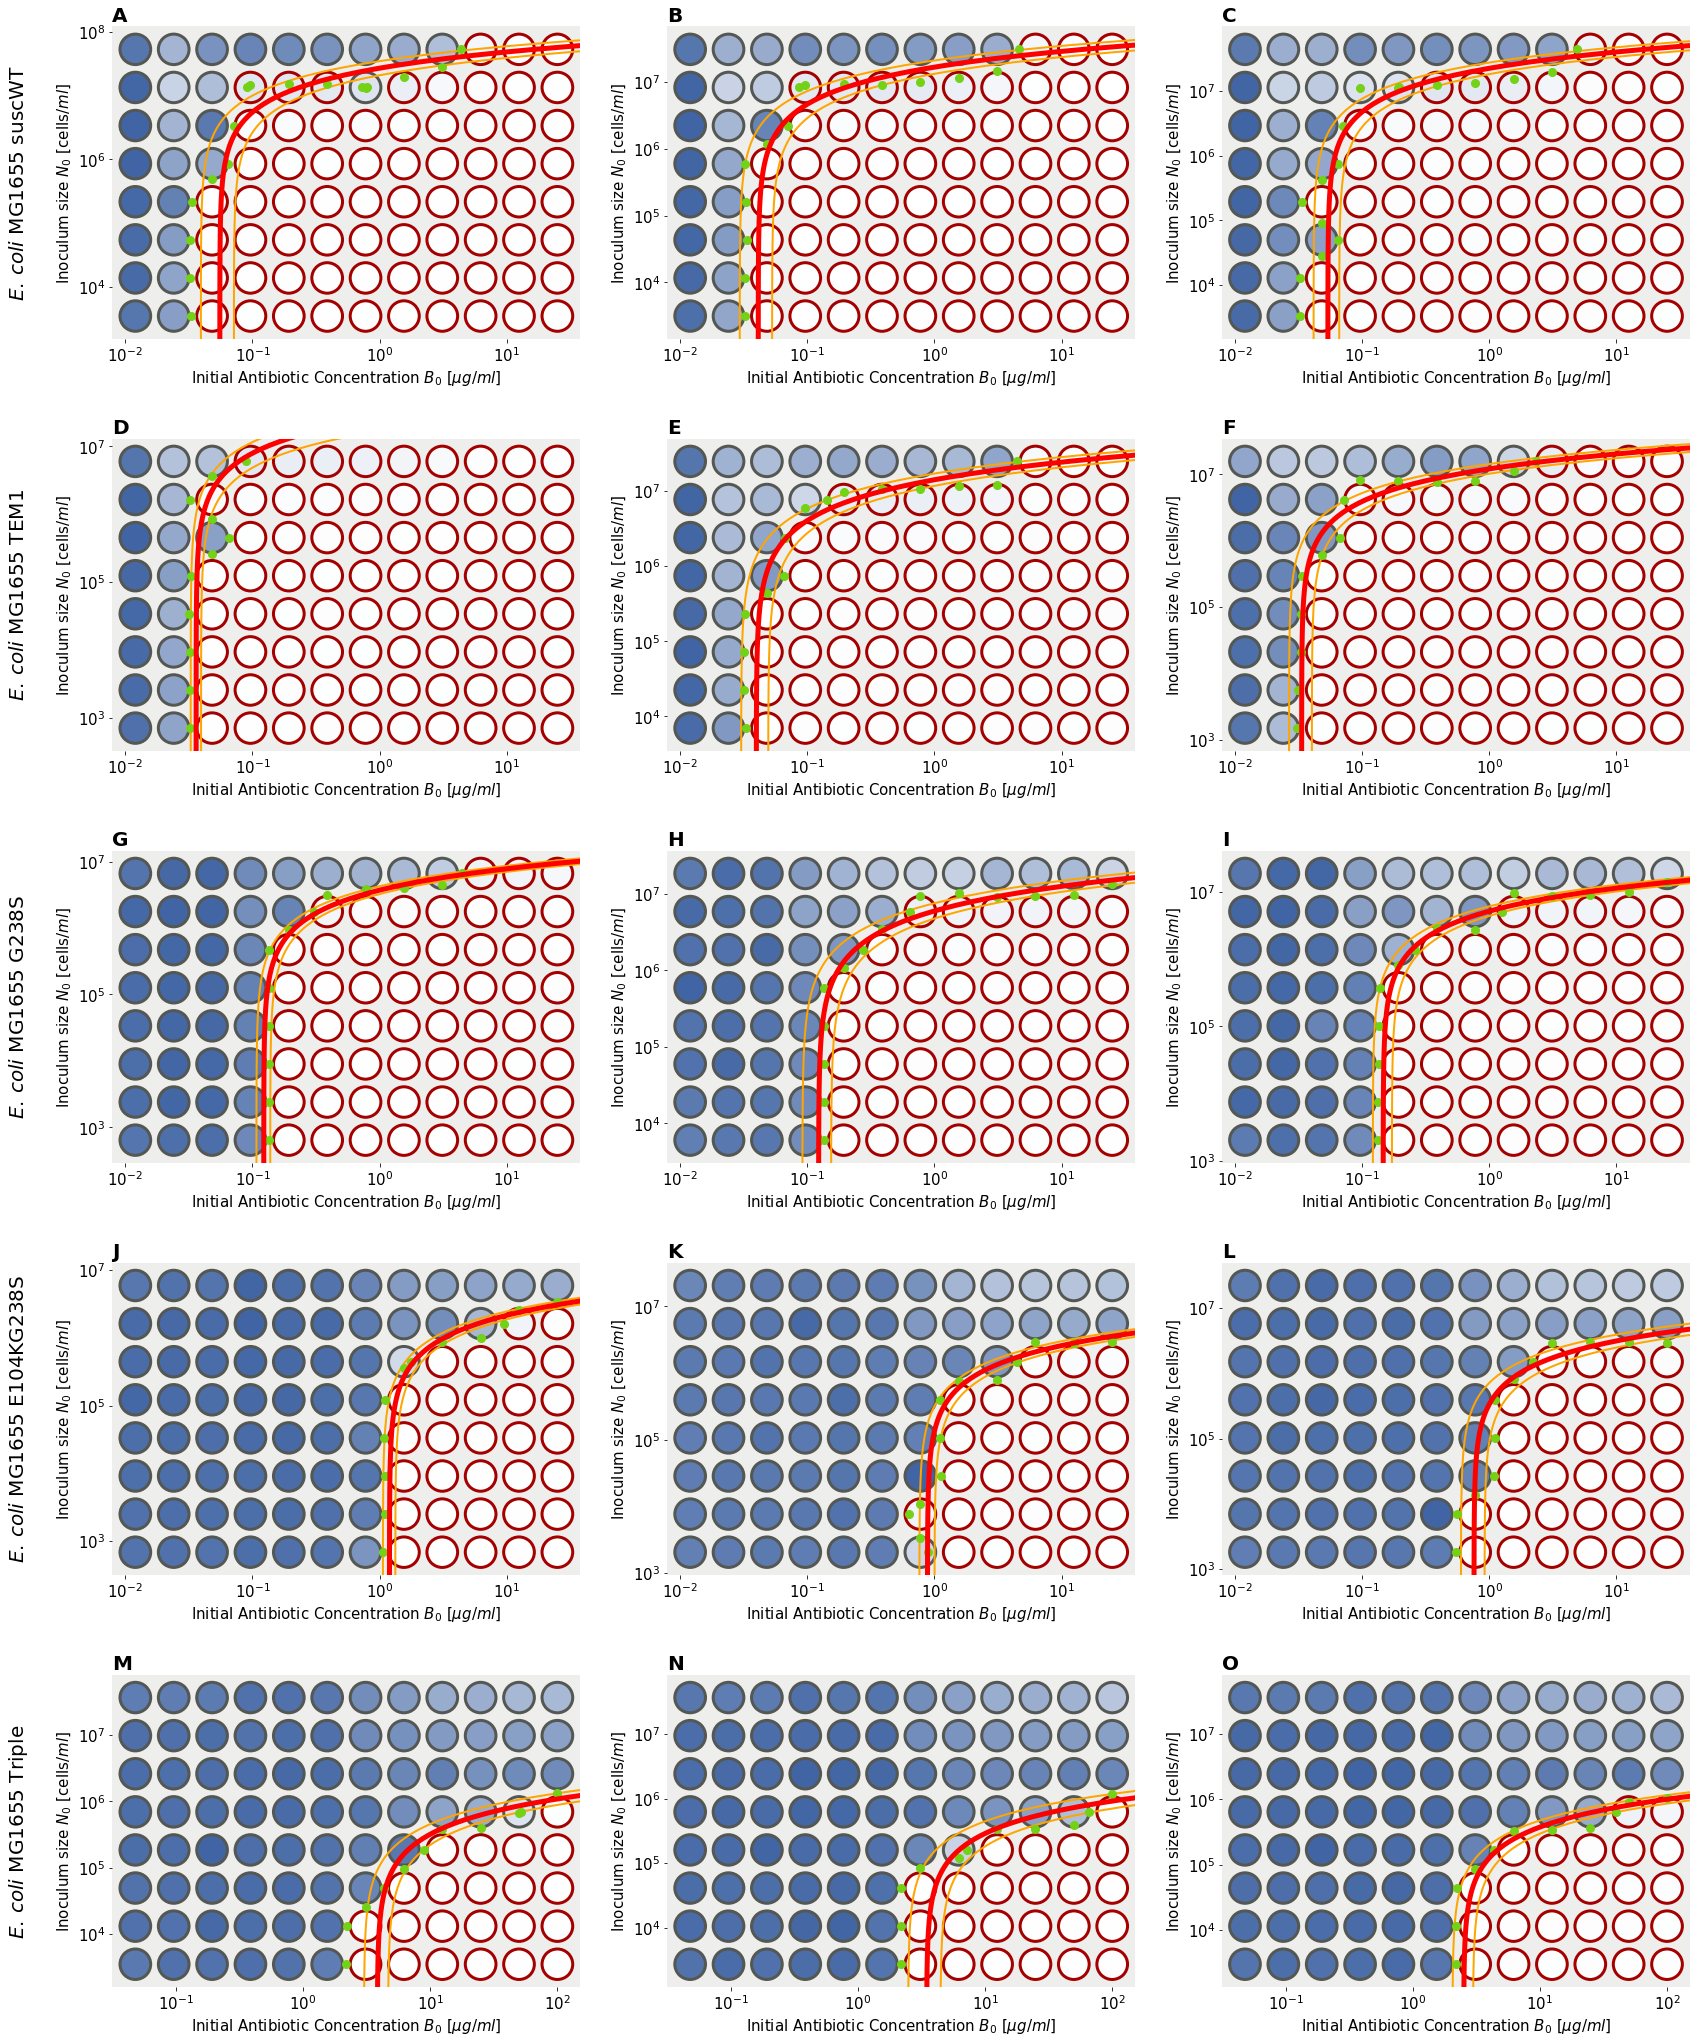

In [4]:
fig,ax = plt.subplots(len(datafiles_cEPS),3,figsize = (8 * 3, 5.8 * len(datafiles_cEPS)))
fig.subplots_adjust(hspace=0.35)
for k,filename in enumerate(datafiles_cEPS):
    basename = os.path.basename(filename)
    
    data = prc.PlateReaderData(infiles = [filename],
                               DesignAssignment = designassignment_cEPS[basename],
                               ForceOrientation = True,
                               ForceEqualDesignSpacing = True,
                               ThresholdLog = True)
    
    platecount = len([t for t in data.titles if not '-IPTG' in t])
    i          = 0

    for j,(fn, title, platedata, designID) in enumerate(data):
        if not '-IPTG' in title:
            design      = data.get_design(designid = designID)
            plate       = pic.PlateImage(platedata, design, fig = fig, ax = ax[k,i], panelID = chr(65 + i + 3*k), Threshold = global_threshold)
            transitions = data.compute_growth_nogrowth_transition(dataID = j, threshold = global_threshold)
            fitdata     = eMSP.estimate_Tau_sMIC_nonlinfit_AsFuncLogN(transitions)

            plate.plot_curve(popsize = transitions[:,1], abconc = transitions[:,0], lw = 0, marker = 'o', markersize = 8, c = '#73d216', zorder = 2)
            
            plate.plot_MSIcurve(tau = fitdata['BlN_tau'], mueff = fitdata['BlN_sMIC'], lw = 5, c = 'red', zorder = 3)
            plate.plot_MSIcurve(tau = fitdata['BlN_tau'] + fitdata['BlN_tau_stddev'], mueff = fitdata['BlN_sMIC'] - fitdata['BlN_sMIC_stddev'], lw = 2, c = 'orange', zorder = 1)
            plate.plot_MSIcurve(tau = fitdata['BlN_tau'] - fitdata['BlN_tau_stddev'], mueff = fitdata['BlN_sMIC'] + fitdata['BlN_sMIC_stddev'], lw = 2, c = 'orange', zorder = 1)
            
            i += 1
            
    ax[k,0].annotate(ChangeEPS_label + ' ' + basename.split('.')[0].split('_')[1], [-0.2,0.50], fontsize = 20, rotation = 90, xycoords = 'axes fraction', ha = 'center', va = 'center')#, weight = 'bold')
fig.tight_layout(pad = 3)
fig.savefig('figS2_ChangeEPS_AllPlates.pdf')

In [5]:
datafiles_cRHO, designassignment_cRHO = ReadDesignAssignment('../ExperimentalData/ChangeRHO/design_assignment.txt')

print(datafiles_cRHO)
print(designassignment_cRHO)

['../ExperimentalData/ChangeRHO/ChangeRHO_G238S.xlsx', '../ExperimentalData/ChangeRHO/ChangeRHO_Triple.xlsx']
{'ChangeRHO_G238S.xlsx': [0, 0, 0, 0, 0, 0, 0, 0], 'ChangeRHO_Triple.xlsx': [0, 0, 0, 0, 1, 1, 1, 1]}


/usr/lib64/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


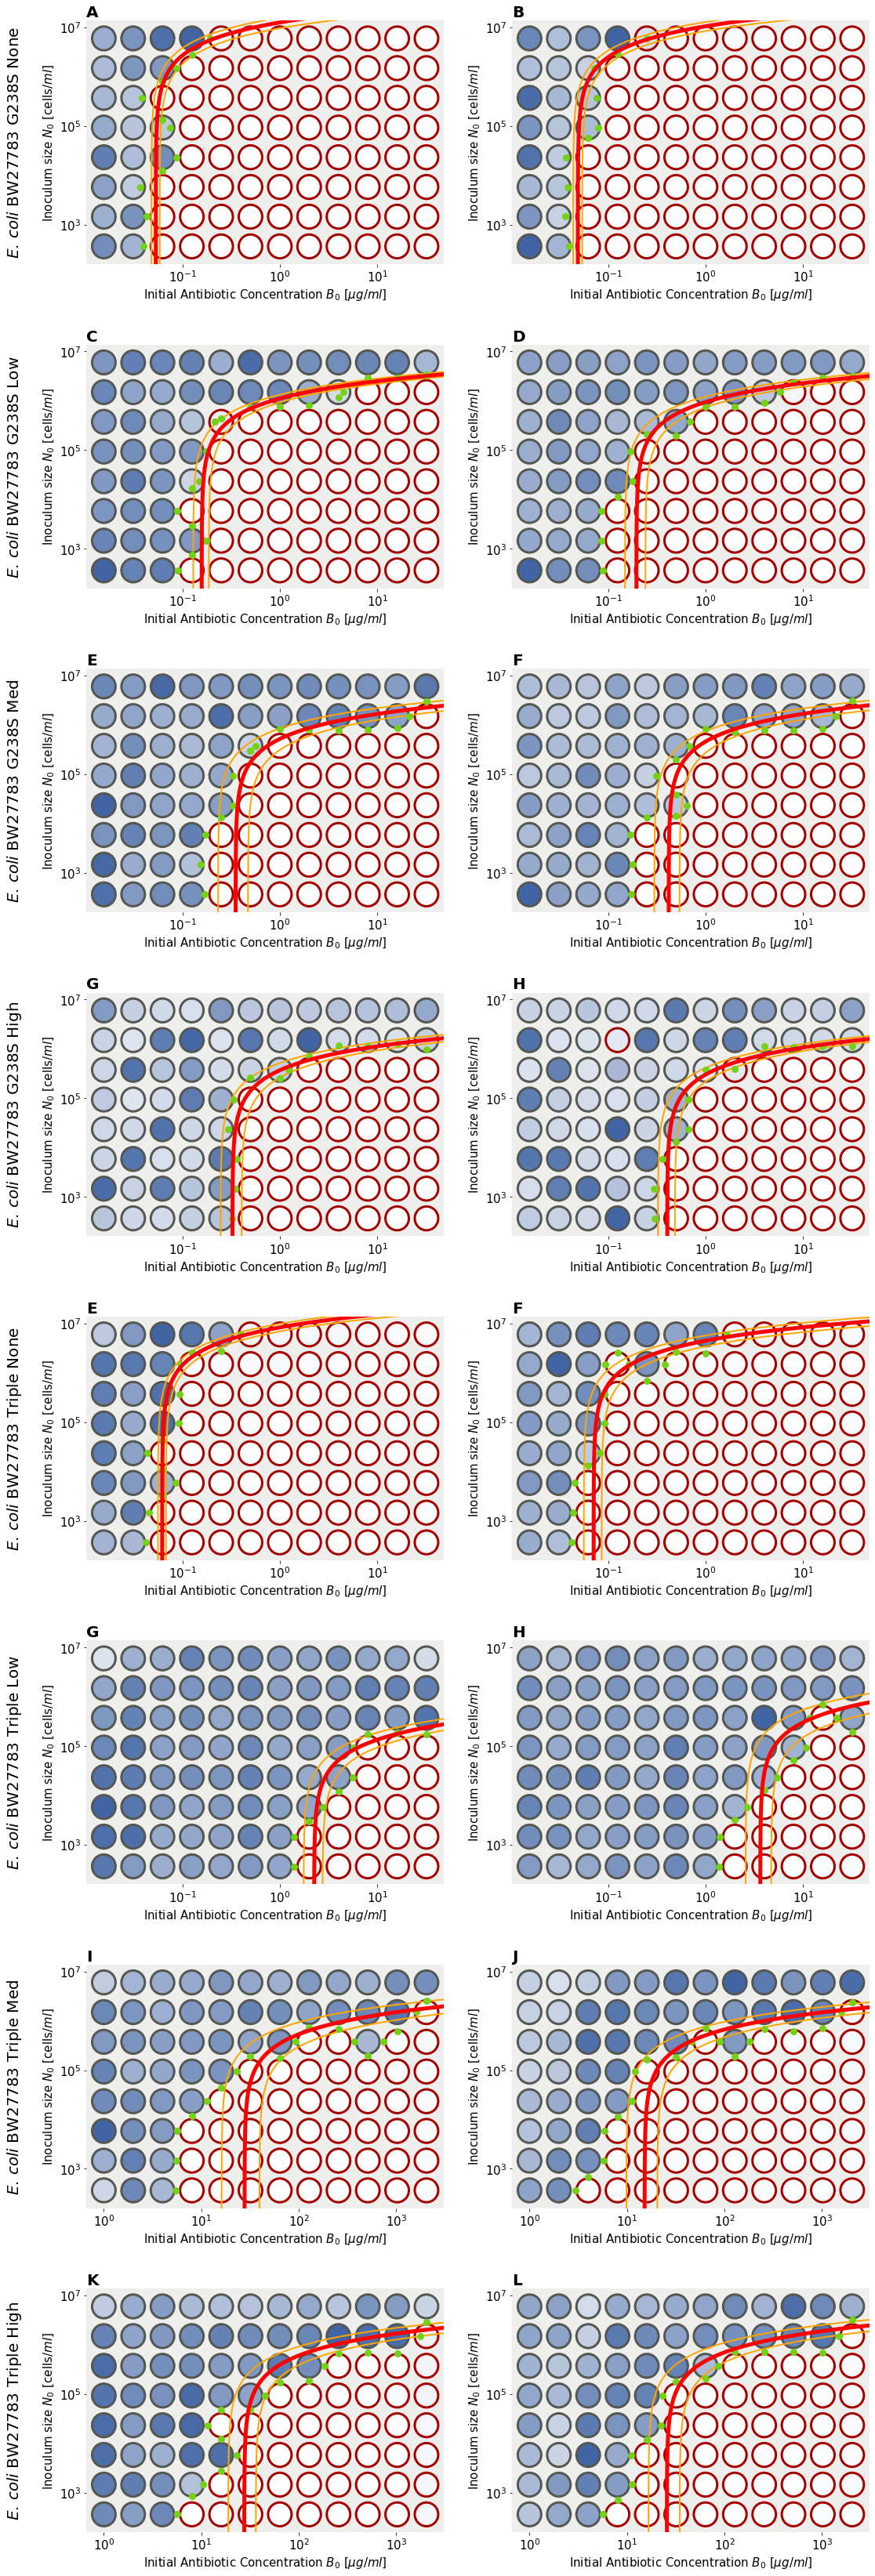

In [6]:
fig,ax = plt.subplots(4*len(datafiles_cRHO),2,figsize = (8 * 2,4 * 5.8 * len(datafiles_cRHO)))
fig.subplots_adjust(hspace=0.35)

for k,filename in enumerate(datafiles_cRHO):
    basename = os.path.basename(filename)
    
    data = prc.PlateReaderData(infiles = [filename],
                               DesignAssignment = designassignment_cRHO[basename],
                               ForceOrientation = True,
                               ForceEqualDesignSpacing = True,
                               ThresholdLog = True)
    
    for j,(fn, title, platedata, designID) in enumerate(data):
        design = data.get_design(designid = designID)
        plate = pic.PlateImage(platedata, design, fig = fig, ax = ax[k*4 + j//2,j%2], Threshold = global_threshold, panelID = chr(65  + j + 4*k))
        transitions = data.compute_growth_nogrowth_transition(dataID = j, threshold = global_threshold)
        fitdata     = eMSP.estimate_Tau_sMIC_nonlinfit_AsFuncLogN(transitions)

        plate.plot_curve(popsize = transitions.T[1], abconc = transitions.T[0], lw = 0, marker = 'o', markersize = 8, c = '#73d216', zorder = 2)

        plate.plot_MSIcurve(tau = fitdata['BlN_tau'], mueff = fitdata['BlN_sMIC'], lw = 5, c = 'red', zorder = 3)
        plate.plot_MSIcurve(tau = fitdata['BlN_tau'] + fitdata['BlN_tau_stddev'], mueff = fitdata['BlN_sMIC'] - fitdata['BlN_sMIC_stddev'], lw = 2, c = 'orange', zorder = 1)
        plate.plot_MSIcurve(tau = fitdata['BlN_tau'] - fitdata['BlN_tau_stddev'], mueff = fitdata['BlN_sMIC'] + fitdata['BlN_sMIC_stddev'], lw = 2, c = 'orange', zorder = 1)
        
        if j%2 == 0:
            ax[4*k + j//2,0].annotate(ChangeRHO_label + ' ' + title[:-2], [-0.2,0.50], fontsize = 20, rotation = 90, xycoords = 'axes fraction', ha = 'center', va = 'center')#, weight = 'bold')

fig.tight_layout(pad = 3)
fig.savefig('figS3_ChangeRHO_AllPlates.pdf')